# Coursera Capstone Project - Part 2

<strong>Michael A Greene, PhD.</strong>

<H4><em>Introduction/Business Problem</em></H4>

In a town with a small number of people, it is absolutely crucial to conduct market research to determine the demand for a particular product. Especially if you are trying to sell that product! In a large city, it may be possible to sustain a business on the fact that with such a large and diverse group of people, some of them are bound to stop in and order. This may not be true in smaller towns where profit margins are razor thin. 

<H5>The purpose of this project is to explore my home town of Bradenton, FL and determine the best place, if any, to open a new dessert shop.</H5> 

This study will take in to account the proximity of other dessert shops, the categories of dessert shops, and the reviews of existing shops. 




<H4><em>Data</em></H4>

I will extract the venue information from Foursquare using a developer account and several API calls. Getting the name and location of a venue within a certain radius is completely <strong>free</strong> up to 500 calls per day with the free developer sandbox account. This is accomplished by following these steps:

<ol>
    <li>Connecting to the Foursquare API with a special value of private keys.</li>
    <li>Creating the query which can be understood by the Foursquare API.</li>
    <li>Extracting the returned data from the HTML code.</li>
</ol>

Once the data is in a python-readable format, I will use Folium to visualize the city and plot the various venues. <strong>K-means clustering</strong>, a machine learning algorithm, will then be used to group similar venues and predict where a new restaurant may be situated in a prime location. 

<H4><em>Methodology</em></H4>

Steps one and two from above can be completed in one call to the foursqaure API. 

In [54]:
import json, requests

url = 'https://api.foursquare.com/v2/venues/search'
bton_fl = '27.498928,-82.574821'

params = dict(
  client_id='GX424RHIAG0SEPY50L4XQ0CP55VMRRODYQ1OEARLZZCHY2NF',
  client_secret='RPWJZUID5KZ2IXNMYCPSR1OLB3L1WVVIQNZJMIPPLUKOT3R1',
  v='20180323',
  ll=bton_fl,
  intent = "browse",
  radius = 2000,
  limit= 500
)
resp = requests.get(url=url, params=params)
data = json.loads(resp.text)

In [55]:
n_res = len(data["response"]["venues"])
print(n_res) # 190

for i in range(n_res-187):
    print(data["response"]["venues"][i])
    print('\n')
print("....etc....")


190
{'id': '4b82ea74f964a520fbec30e3', 'name': 'Central Library', 'contact': {}, 'location': {'address': '1301 1st Ave W', 'crossStreet': 'at 14 St W', 'lat': 27.49876513403457, 'lng': -82.57469677521266, 'labeledLatLngs': [{'label': 'display', 'lat': 27.49876513403457, 'lng': -82.57469677521266}], 'distance': 21, 'postalCode': '34205', 'cc': 'US', 'city': 'Bradenton', 'state': 'FL', 'country': 'United States', 'formattedAddress': ['1301 1st Ave W (at 14 St W)', 'Bradenton, FL 34205', 'United States']}, 'categories': [{'id': '4bf58dd8d48988d12f941735', 'name': 'Library', 'pluralName': 'Libraries', 'shortName': 'Library', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/library_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'beenHere': {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}, 'referralId': 'v-1555342379', 'venueChains': [], 'hasPerk': F

Let's pick the first one to explore the results.

In [56]:
res_keys = data["response"]["venues"][0].keys()
print(res_keys)

dict_keys(['id', 'name', 'contact', 'location', 'categories', 'verified', 'stats', 'beenHere', 'referralId', 'venueChains', 'hasPerk'])


In [57]:
for k,v in data["response"]["venues"][12].items():
    print(k,"----",v)
    print("\n")

id ---- 4f34341ae4b08ff3ca8822ec


name ---- Falcon Tennis Courts


contact ---- {}


location ---- {'lat': 27.498928, 'lng': -82.574819, 'labeledLatLngs': [{'label': 'display', 'lat': 27.498928, 'lng': -82.574819}], 'distance': 0, 'postalCode': '34205', 'cc': 'US', 'city': 'Bradenton', 'state': 'FL', 'country': 'United States', 'formattedAddress': ['Bradenton, FL 34205', 'United States']}


categories ---- [{'id': '4e39a956bd410d7aed40cbc3', 'name': 'Tennis Court', 'pluralName': 'Tennis Courts', 'shortName': 'Tennis Court', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/stadium_tennis_', 'suffix': '.png'}, 'primary': True}]


verified ---- False


stats ---- {'tipCount': 0, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}


beenHere ---- {'count': 0, 'lastCheckinExpiredAt': 0, 'marked': False, 'unconfirmedCount': 0}


referralId ---- v-1555342379


venueChains ---- []


hasPerk ---- False




In [58]:
import numpy as np 

ven = data["response"]["venues"]
names_list = [n["name"] for n in ven]
lat_list = [l["location"]["lat"] for l in ven]
lng_list = [l["location"]["lng"] for l in ven]
cat_list=[]
for v in ven:
    try:
        cat_list.append(v["categories"][0]["shortName"])
    except IndexError:
        cat_list.append(np.nan)
        continue
    
## Verify ##
dic = {
    "Name":names_list,
    "Latitude":lat_list,
    "Longitude":lng_list,
    "Category":cat_list,
}
for v in dic.values():
    print(len(v))

190
190
190
190


We've extracted the data, so let's now create a pandas DataFrame. 

In [59]:
import pandas as pd

df = pd.DataFrame({
    "Name":names_list,
    "Latitude":lat_list,
    "Longitude":lng_list,
    "Category":cat_list,
})

print(df.head().to_string())
print(df.info())

                                Name   Latitude  Longitude         Category
0                    Central Library  27.498765 -82.574697          Library
1                Bradenton Riverwalk  27.499282 -82.567566   Scenic Lookout
2  Downtown Bradenton Farmers Market  27.496181 -82.573458  Farmer's Market
3  The Freckled Fin and Public House  27.498928 -82.574819      Music Venue
4  PIER 22 Restaurant Patio Catering  27.500480 -82.573531         American
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 4 columns):
Name         190 non-null object
Latitude     190 non-null float64
Longitude    190 non-null float64
Category     182 non-null object
dtypes: float64(2), object(2)
memory usage: 6.0+ KB
None


Let's explore the various cateories present in our daatset

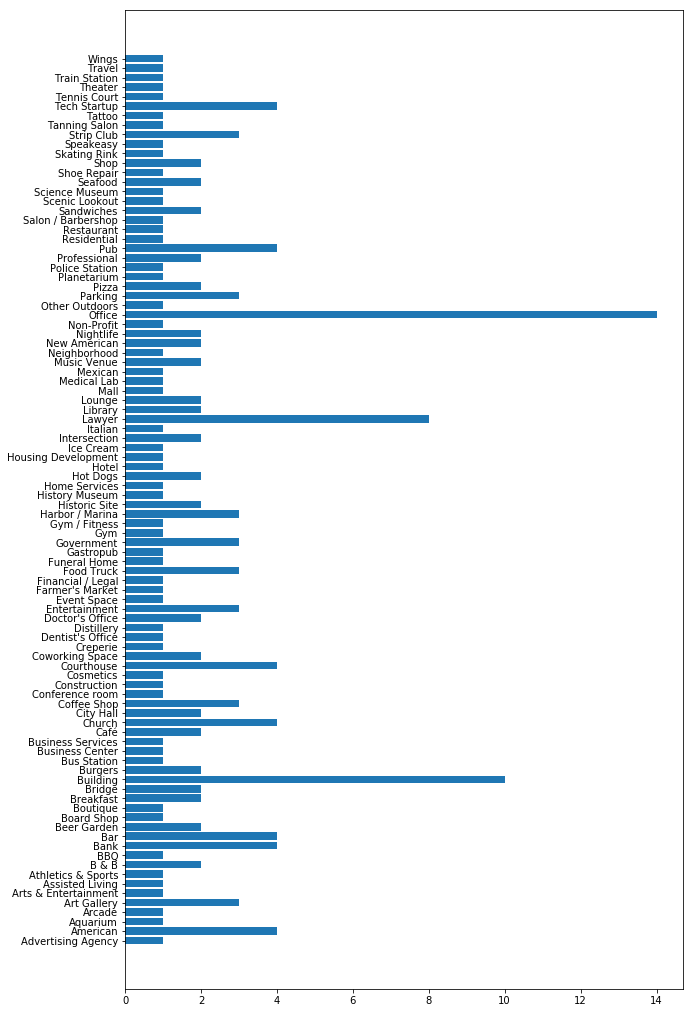

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,18))
plt.barh(y = df.groupby("Category").size().index,
       width = df.groupby("Category").size())
plt.show()



Too many to be useful right now! Let's scrape Foursquare's major categories and give the categories a more general label.

In [61]:
fsq_cat = r"https://developer.foursquare.com/docs/resources/categories"

url = 'https://api.foursquare.com/v2/venues/categories'
params = dict(
  client_id='GX424RHIAG0SEPY50L4XQ0CP55VMRRODYQ1OEARLZZCHY2NF',
  client_secret='RPWJZUID5KZ2IXNMYCPSR1OLB3L1WVVIQNZJMIPPLUKOT3R1',
  v='20180323')
cats = requests.get(url=url, params=params)
catj = json.loads(cats.text)

In [62]:
"""
Parent
    Child
        Subchild <Ignored>
"""
cat_resp = catj["response"]["categories"]
cats_dict = {}
for p in range(len(cat_resp)): ## For each parent category
    child_list = []
    for c in range(len(cat_resp[p]["categories"])): ## For each child category
        child_list.append(cat_resp[p]["categories"][c]["shortName"])
        if len(cat_resp[p]["categories"][c]["categories"]) != 0: ## If there is a further subcategory
            for s in range(len(cat_resp[p]["categories"][c]["categories"])):
                child_list.append(cat_resp[p]["categories"][c]["categories"][s]["shortName"])
    cats_dict[cat_resp[p]["name"]] = child_list
    
print(cats_dict.keys())

dict_keys(['Arts & Entertainment', 'College & University', 'Event', 'Food', 'Nightlife Spot', 'Outdoors & Recreation', 'Professional & Other Places', 'Residence', 'Shop & Service', 'Travel & Transport'])


In [63]:
def general_labeler(specific, trns_dict):
    """
    This function takes an element, specific, and checks to see if it's in the values of the trns_dict.
    The function then returns the key of that value
    """
    for k,v in trns_dict.items():
        ret = specific
        if specific in v:
            ret = k
            break
        else:
            continue
    return ret 
        
df["General_Label"] = [general_labeler(s, cats_dict) for s in df["Category"]]
print(df.head())
df = df.dropna(how="any", axis=0).reset_index(drop=True)
print(df.groupby("General_Label").size())

                                Name   Latitude  Longitude         Category  \
0                    Central Library  27.498765 -82.574697          Library   
1                Bradenton Riverwalk  27.499282 -82.567566   Scenic Lookout   
2  Downtown Bradenton Farmers Market  27.496181 -82.573458  Farmer's Market   
3  The Freckled Fin and Public House  27.498928 -82.574819      Music Venue   
4  PIER 22 Restaurant Patio Catering  27.500480 -82.573531         American   

           General_Label  
0   College & University  
1  Outdoors & Recreation  
2         Shop & Service  
3   Arts & Entertainment  
4                   Food  
General_Label
Arts & Entertainment           17
College & University            4
Food                           34
Nightlife Spot                 18
Outdoors & Recreation          11
Professional                    2
Professional & Other Places    58
Residence                       3
Shop & Service                 27
Travel & Transport              8
dtype: in

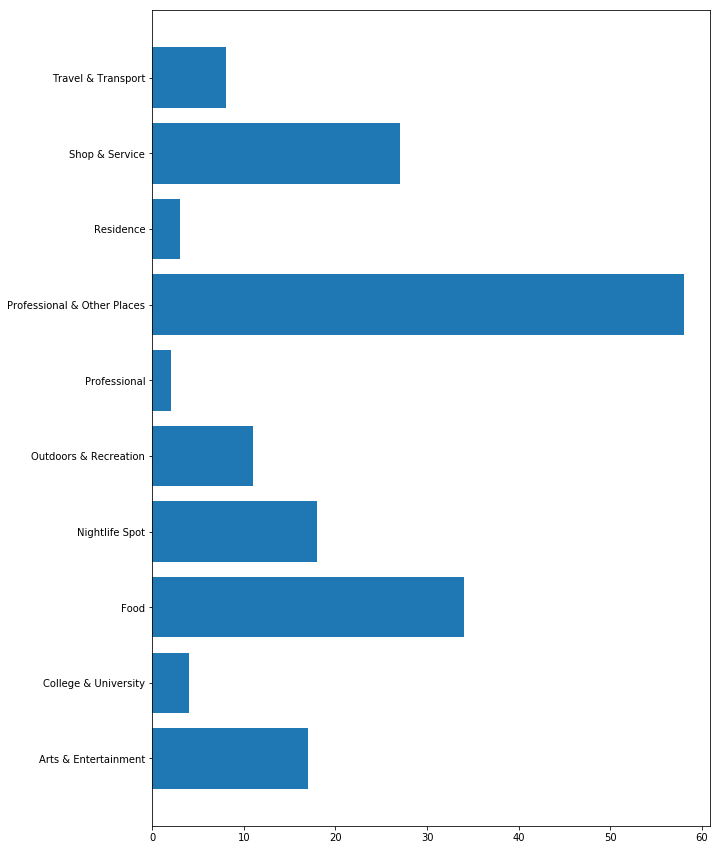

In [64]:
plt.figure(figsize=(10,15))
plt.barh(y = df.groupby("General_Label").size().index,
       width = df.groupby("General_Label").size())
plt.show()

Great. Let's now visualize these locations on a Folium map. 

In [65]:
import folium
#bton_fl = '27.498928,-82.574821'
m = folium.Map(location=[27.498928,-82.574821],
               zoom_start=12.5,
               width=500,
               height=500)

color_dict = {
"Arts & Entertainment":'red',
"College & University":'purple',
"Food":'green',
"Nightlife Spot":'darkpurple',
"Outdoors & Recreation":'orange',
"Professional":'black',
"Professional & Other Places":'black',
"Residence":'white',
"Shop & Service":'lightgray',
"Travel & Transport":'pink'
}

from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

data_labels = list(zip(df["Latitude"].values, 
                       df["Longitude"].values, 
                       df["Name"], 
                       df["General_Label"]))

for z in data_labels:
    color = color_dict[z[3]]
    m_name = str(z[2])
    pop = folium.Popup(z[2], parse_html=True)
    folium.Marker([z[0], z[1]], popup=pop, icon=folium.Icon(color=color)).add_to(marker_cluster)

m

Let's now begin the process of using K-means clustering to identify the centroids of "Food" clusters. Let's begin by identifying the right number of clusters using the elbow method. 


(182, 2)


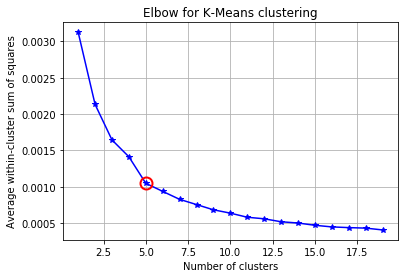

In [66]:
"""
Code here inspired by 
https://nbviewer.jupyter.org/github/nborwankar/LearnDataScience/blob/master/notebooks/D3.%20K-Means%20Clustering%20Analysis.ipynb
"""

from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

X = df[["Latitude", "Longitude"]]
print(X.shape)
K = range(1,20)

models = [kmeans(X,k) for k in K] 
centroids = [cent for (cent,var) in models] 

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]  
kIdx = 4
n_clusters = kIdx



# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', 
        markersize=12, markeredgewidth=2, 
        markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

In [67]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

df["Cluster_Label"] = kmeans.labels_

print(df.head())

                                Name   Latitude  Longitude         Category  \
0                    Central Library  27.498765 -82.574697          Library   
1                Bradenton Riverwalk  27.499282 -82.567566   Scenic Lookout   
2  Downtown Bradenton Farmers Market  27.496181 -82.573458  Farmer's Market   
3  The Freckled Fin and Public House  27.498928 -82.574819      Music Venue   
4  PIER 22 Restaurant Patio Catering  27.500480 -82.573531         American   

           General_Label  Cluster_Label  
0   College & University              2  
1  Outdoors & Recreation              2  
2         Shop & Service              2  
3   Arts & Entertainment              2  
4                   Food              2  


Each venue now has a cluster label. Let's see which labels contains which General Labels. 

Initially, clusters 0 and 4 were exactly the same, so I reduced the number of clusters by 1 so get the following groups.

In [68]:
cluster_dict = {}

for c in range(kIdx):
    cluster_dict[c] = set(df[df["Cluster_Label"] == c]["General_Label"])

for k,v in cluster_dict.items():
    print(k, "---", v)

0 --- {'Residence', 'Shop & Service', 'Food', 'Travel & Transport', 'Arts & Entertainment', 'Professional & Other Places', 'Outdoors & Recreation'}
1 --- {'Outdoors & Recreation'}
2 --- {'Shop & Service', 'Professional', 'Food', 'Nightlife Spot', 'Travel & Transport', 'Arts & Entertainment', 'Outdoors & Recreation', 'College & University', 'Professional & Other Places'}
3 --- {'Food'}


"Food" shows up in three of the clusters, so let's open up a food store in the center of cluster where "food" doesn't show up, number two (index 1). 

<H4><em>Results</em></H4>

My new restaurant will be placed at the centroid of a cluster of venues that don't have the "Food" category. 

In [69]:
my_new_rest = list(kmeans.cluster_centers_[1])

m2 = folium.Map(location=my_new_rest,
               zoom_start=12.5,
               width=500,
               height=500)
folium.Marker(my_new_rest, popup="My New Restaurant", icon=folium.Icon(color="purple")).add_to(m2)
m2

It looks like a prime spot right on the river!

<H4><em>Discussion</em></H4>

Let's check to see how many other "Food" venues may be nearby.

In [70]:
food_df = df[df["General_Label"] == "Food"]

m3 = folium.Map(location=my_new_rest,
               zoom_start=10,
               width=500,
               height=500)


data_labels_f = list(zip(food_df["Latitude"].values, 
                       food_df["Longitude"].values, 
                       food_df["Name"], 
                       food_df["General_Label"]))

for z in data_labels_f[0:3]:
    color = color_dict[z[3]]
    m_name = str(z[2])
    pop = folium.Popup(z[2], parse_html=True)
    folium.Marker([z[0], z[1]], popup=pop, icon=folium.Icon(color=color)).add_to(m3)
folium.Marker(my_new_rest, popup="My New Restaurant", icon=folium.Icon(color="purple")).add_to(m3)    
m3

So the most obvious conclusion here is that cluster number 4 (index 3) is in Sarasota, Bradenton's southern sister. 

This cluster has only one venue, along with cluster number 2 (index 1). 

In [73]:
print(df[(df["Cluster_Label"] == 1) | (df["Cluster_Label"] == 3) ])

                             Name   Latitude  Longitude         Category  \
10   Kathleen D Sailing Catamaran  27.334122 -82.545825  Harbor / Marina   
162          Little Caesars Pizza  27.533748 -82.502148            Pizza   

             General_Label  Cluster_Label  
10   Outdoors & Recreation              1  
162                   Food              3  


This result is likely an issue with the Foursqare return query. I think that Foursqaure is only returning venues within a certain radius, but at the same time limiting the results somehow, even after adjusting the search radius. In a future update, I will conduct multiple queries to Foursquare and test my hypothesis by joining the results together for a larger number of venues. 

<H4><em>Conclusion</em></H4>

Thank you for taking the time to read and reflect with me the process of conducting a short data science project for the satisfaction of IBM's Professional Data Scientist certification process through Coursera. In summary, I: 

<ul>
<li>Outlined the procedure and background - predicting where to set up a new restaurant in my hometown</li>
<li>Defined the required data and how to collect it - Foursquare using a free developer account</li>
<li>Described the data once I got it - pandas with matplotlib and Folium</li>
<li>Used K-means clustering to group venues by location and category - predicting a restaurant where there aren't any 'food' categories</li>
<li>Write up a summary and publish it to a blog or social media post</li>
</ul>

Please feel free to comment, critique, and leave your reviews however you wish. 

<H2>Thank you again,</H2>
<H5>Michael A Greene, PhD</H5><br/>

[LinkedIn](https://www.linkedin.com/in/michael-greene-8761b852/)<br/>
[Github](http://www.github.com/mgreene02)<br/>
[Kaggle](http://www.kaggle.com/mgreene02)<br/>